In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

np.random.seed(0)


In [2]:
data = pd.read_csv('StreamflowT1.csv') 
data = data.loc[:, ~data.columns.str.startswith('Unnamed')]


In [3]:
# Drop rows with 'nan' values
data = data.dropna()

# Then split into features (X) and labels (Y)
X = data.drop(columns=['0240251SF']).values.astype(np.float32)
Y = data['0240251SF'].values.reshape(-1, 1).astype(np.float32)  # Reshape to be 2D array, as expected by model

# Check again for 'nan' in X and Y
if np.isnan(X).any():
    print("There are still nan values in X")
if np.isnan(Y).any():
    print("There are still nan values in Y")

# Print new number of rows
print("Total number of rows after dropping 'nan': ", data.shape[0])


Total number of rows after dropping 'nan':  6566


In [4]:
from sklearn.model_selection import train_test_split

# Split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Training set size: ", X_train.shape[0])
print("Test set size: ", X_test.shape[0])


Training set size:  5252
Test set size:  1314


In [5]:


class PSO:
    def __init__(self, population_size, dimensions, cognitive_weight, social_weight, inertia_weight, start_velocity=0.5, end_velocity=0.1):
        self.population_size = population_size
        self.dimensions = dimensions
        self.population = [Particle(dimensions) for _ in range(population_size)]
        self.global_best_position = np.copy(self.population[0].position)
        self.cognitive_weight = cognitive_weight
        self.social_weight = social_weight
        self.inertia_weight = inertia_weight
        self.start_velocity = start_velocity
        self.end_velocity = end_velocity
        self.velocity = start_velocity
    
    def optimize(self, loss_func, iterations, reinit_interval=50, reinit_ratio=0.25):
        best_fitness = float('inf')

        for i in range(iterations):
            for particle in self.population:
                fitness = loss_func(particle.position)

                # Update personal best
                if fitness < loss_func(particle.best_position):
                    particle.best_position = np.copy(particle.position)

                # Update global best
                if fitness < loss_func(self.global_best_position):
                    self.global_best_position = np.copy(particle.position)
                    best_fitness = fitness

            for particle in self.population:
                cognitive_velocity = self.cognitive_weight * np.random.rand() * (particle.best_position - particle.position)
                social_velocity = self.social_weight * np.random.rand() * (self.global_best_position - particle.position)
                particle.velocity = self.inertia_weight * particle.velocity + cognitive_velocity + social_velocity

                # Limit and adjust velocities
                self.velocity = max(self.velocity, self.end_velocity)
                particle.velocity = np.clip(particle.velocity, -self.velocity, self.velocity)
                particle.position += particle.velocity

            # Periodically re-initialize a portion of the swarm
            if (i+1) % reinit_interval == 0:
                num_to_reinit = int(self.population_size * reinit_ratio)
                for _ in range(num_to_reinit):
                    idx = np.random.randint(0, self.population_size)
                    self.population[idx] = Particle(self.dimensions)

            # Decrease the velocity linearly
            self.velocity -= (self.start_velocity - self.end_velocity) / iterations

        return self.global_best_position, best_fitness


In [6]:
class ELM:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        # Weights and biases
        self.W = tf.Variable(tf.random.normal([self.input_dim, self.hidden_dim]), trainable=False, dtype=tf.float32)
        self.b = tf.Variable(tf.random.normal([self.hidden_dim]), trainable=False, dtype=tf.float32)
        self.beta = tf.Variable(tf.zeros([self.hidden_dim, self.output_dim]), trainable=True, dtype=tf.float32)

    def model(self, X):
        # Input to hidden layer
        hidden_layer = tf.nn.relu(tf.add(tf.matmul(X, self.W), self.b))
        
        # Hidden layer to output
        output_layer = tf.matmul(hidden_layer, self.beta)
        
        return output_layer

    def loss(self, X, Y):
        Y_pred = self.predict(X)
        return tf.reduce_mean(tf.square(Y - Y_pred))

    def train(self, X, Y, epochs=5):
        pso = PSO(
        population_size=200, 
        dimensions=self.hidden_dim * self.output_dim, 
        cognitive_weight=0.8, 
        social_weight=0.8, 
        inertia_weight=0.9)

        for epoch in range(epochs):
            loss_func = lambda positions: (self.beta.assign(tf.reshape(tf.convert_to_tensor(positions, dtype=tf.float32), (self.hidden_dim, self.output_dim))), self.loss(X, Y))[-1]


            best_position, best_loss = pso.optimize(loss_func, iterations=  100)

            # Reshape best position to match shape of self.beta and convert to float32
            best_position = tf.reshape(best_position.astype('float32'), self.beta.shape)

            # Update beta
            self.beta.assign(best_position)

            if (epoch+1) % 50 == 0:
                print(f'Epoch: {epoch+1}, Loss: {self.loss(X, Y).numpy()}')
    def predict(self, X):
        return self.model(X)

In [7]:
from sklearn.model_selection import train_test_split

# Split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Training set size: ", X_train.shape[0])
print("Test set size: ", X_test.shape[0])

# Initialize ELM
elm = ELM(input_dim=X.shape[1], hidden_dim=15, output_dim=1)

# Train model
elm.train(X_train, Y_train, epochs=20)

# Predict on test data
Y_pred = elm.predict(X_test)

# Print predictions
print(Y_pred)


Training set size:  5252
Test set size:  1314


NameError: name 'Particle' is not defined

In [ ]:
import numpy as np

# Assuming Y_pred and Y_test are numpy arrays or lists of predicted and true values, respectively.

# Step 1: Calculate the squared error for each predicted value and corresponding true value
squared_errors = (Y_pred - Y_test)**2

# Step 2: Compute the mean of the squared errors
mean_squared_error = np.mean(squared_errors)

# Step 3: Take the square root of the mean squared error to get the RMSE
rmse = np.sqrt(mean_squared_error)

print("Root Mean Squared Error:", rmse)


Root Mean Squared Error: 0.056427784


In [ ]:
import numpy as np

# Assuming Y_pred and Y_test are numpy arrays or lists of predicted and true values, respectively.

# Step 1: Calculate the mean of the true values
mean_y = np.mean(Y_test)

# Step 2: Calculate the total sum of squares (TSS)
tss = np.sum((Y_test - mean_y) ** 2)

# Step 3: Calculate the residual sum of squares (RSS)
rss = np.sum((Y_test - Y_pred) ** 2)

# Step 4: Calculate R-squared
r_squared = 1 - (rss / tss)

print("R-squared:", r_squared)


R-squared: 0.5349509418010712


tf.Tensor(
[[0.10527012]
 [0.0660775 ]
 [0.0708288 ]
 ...
 [0.02427721]
 [0.0875784 ]
 [0.18469228]], shape=(1314, 1), dtype=float32)


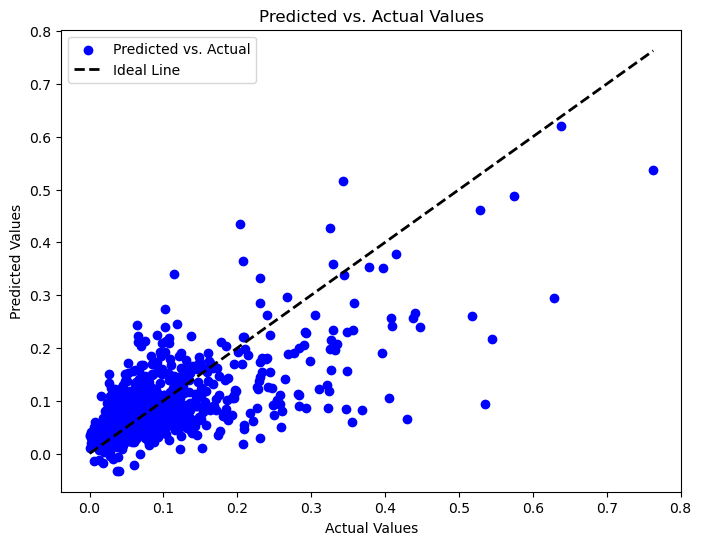

In [ ]:
import matplotlib.pyplot as plt

# Draw a chart of predicted vs. actual values
print(Y_pred)

# Draw a chart of predicted vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, Y_pred, color='blue', label='Predicted vs. Actual')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], 'k--', lw=2, label='Ideal Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values')
plt.legend()
plt.show()
